<a href="https://colab.research.google.com/github/dbusn/process-mining-group-5/blob/main/RNN_Time_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#!pip install matplotlib --upgrade

In [ ]:
import numpy as np
import pandas as pd
import re
from tqdm import tqdm
import datetime as datetime
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from keras.models import Sequential, load_model, Model
from keras.layers import Input, Dense, LSTM, Dropout, BatchNormalization
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.optimizer_v2 import nadam as nadam_v2
import os
import math
from sklearn.metrics import accuracy_score, confusion_matrix, r2_score, mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
import matplotlib

In [ ]:
#!pip install tensorflow-gpu

# 0. GPU Setting and Import CSV (https://colab.research.google.com/notebooks/gpu.ipynb#scrollTo=sXnDmXR7RDr2)

The requirements to use the cuDNN implementation are:

activation == tanh

recurrent_activation == sigmoid

recurrent_dropout == 0

unroll is False

use_bias is True

Inputs, if use masking, are strictly right-padded.

Eager execution is enabled in the outermost context.

In [ ]:
%tensorflow_version 2.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
    raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [ ]:
from google.colab import drive
drive.mount('/content/drive')
df_train = pd.read_csv("/content/drive/MyDrive/DBL Process Mining/Data/Split/bpi2017_train_filtered.csv", parse_dates = ['time:timestamp'])
df_val = pd.read_csv("/content/drive/MyDrive/DBL Process Mining/Data/Split/bpi2017_val_filtered.csv", parse_dates = ['time:timestamp'])
df_test = pd.read_csv("/content/drive/MyDrive/DBL Process Mining/Data/Split/bpi2017_test_filtered.csv", parse_dates = ['time:timestamp'])

# The default name indicating the case ID is case:concept:name
# concept:name is the event
# time:timestamp is the corresponding timestamp
# Load the datasets, sort them on case and consequently timestamp, then reset the index
df_train = df_train.sort_values(by = ['case:concept:name', 'time:timestamp']).reset_index(drop = True)
df_val = df_val.sort_values(by = ['case:concept:name', 'time:timestamp']).reset_index(drop = True)
df_test = df_test.sort_values(by = ['case:concept:name', 'time:timestamp']).reset_index(drop = True)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Global Feature 1

df_train["case_occurrence_nr"] = df_train.groupby(['case:concept:name'])['time:timestamp'].cumcount().tolist()
df_val["case_occurrence_nr"] = df_val.groupby(['case:concept:name'])['time:timestamp'].cumcount().tolist()
df_test["case_occurrence_nr"] = df_test.groupby(['case:concept:name'])['time:timestamp'].cumcount().tolist()

min_max_scaler_occur = MinMaxScaler()
df_train['nor_case_occurrence_nr'] = min_max_scaler_occur.fit_transform(np.array(df_train['case_occurrence_nr']).reshape(-1, 1))
df_val['nor_case_occurrence_nr'] = min_max_scaler_occur.transform(np.array(df_val['case_occurrence_nr']).reshape(-1, 1))
df_test['nor_case_occurrence_nr'] = min_max_scaler_occur.transform(np.array(df_test['case_occurrence_nr']).reshape(-1, 1))

In [ ]:
# Global Feature 2

def case_in_hr(df):
    df['date'] = df['time:timestamp'].dt.date
    df['hour'] = df['time:timestamp'].dt.hour
    df_1 = df.groupby(['date', 'hour']).count()[['case:concept:name']].reset_index()
    df_1.rename(columns = {'case:concept:name': 'case_nr_per_hr'}, inplace = True)
    df = pd.merge(df, df_1, on = ['date', 'hour'], how = "left")
    df.drop(columns = ['date', 'hour'], inplace = True)
    return df

df_train = case_in_hr(df_train)
df_val = case_in_hr(df_val)
df_test = case_in_hr(df_test)

min_max_scaler_case = MinMaxScaler()
df_train['nor_case_nr_per_hr'] = min_max_scaler_case.fit_transform(np.array(df_train['case_nr_per_hr']).reshape(-1, 1))
df_val['nor_case_nr_per_hr'] = min_max_scaler_case.transform(np.array(df_val['case_nr_per_hr']).reshape(-1, 1))
df_test['nor_case_nr_per_hr'] = min_max_scaler_case.transform(np.array(df_test['case_nr_per_hr']).reshape(-1, 1))

# 1. Normalization on Time Difference

In [ ]:
# Normalize time difference so that the time difference's value is within 0 and 1
min_max_scaler = MinMaxScaler()
df_train['nor_future_time_diff'] = min_max_scaler.fit_transform(np.array(df_train['future_time_diff']).reshape(-1, 1))
# Use the range from training data on validation and test data
df_val['nor_future_time_diff'] = min_max_scaler.transform(np.array(df_val['future_time_diff']).reshape(-1, 1))
df_test['nor_future_time_diff'] = min_max_scaler.transform(np.array(df_test['future_time_diff']).reshape(-1, 1))

# 2. One-hot Encoding

In [ ]:
def onehot_now(df):
    # Extract categorical and numerical variables
    df_cat = df[['concept:name', 'lifecycle:transition', 'EventOrigin', 'Action']]
    df_num = df[['nor_time_since_last_event', 'nor_time_since_case_starts', 'nor_time_since_midnight', 'nor_time_since_week_start', 'position', 'nor_case_occurrence_nr', 'nor_case_nr_per_hr']]
    # Convert categorical variable columns to one-hot encoding (A large matrix with dummy variables is made)
    enc = OneHotEncoder(handle_unknown = 'ignore', sparse = False)
    enc.fit(df_train[['concept:name', 'lifecycle:transition', 'EventOrigin', 'Action']])
    transformed = enc.transform(df_cat)
    # Create a dataframe using the newly created matrix
    df_ohe = pd.DataFrame(transformed, columns = enc.get_feature_names())
    # Combine dummy dataframe with numerical dataframe
    df_ohe = pd.concat([df_ohe, df_num], axis = 1)
    return df_ohe

df_train_now = onehot_now(df_train)
df_val_now = onehot_now(df_val)
df_test_now = onehot_now(df_test)

enc = OneHotEncoder(handle_unknown = 'ignore', sparse = False)
df_train_next = enc.fit_transform(df_train[['next:concept:name']])
df_val_next = enc.transform(df_val[['next:concept:name']])
df_test_next = enc.transform(df_test[['next:concept:name']])

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [ ]:
# Source: https://towardsdatascience.com/how-to-reshape-data-and-do-regression-for-time-series-using-lstm-133dad96cd00

def lstm_data_transform(x_data, y_data_1, y_data_2, num_steps):
    # Reshape the feature array to (621131, 27, 1) so that it fulfills the format requirement of LSTM (Number Of Examples, Time Steps, Features Per Step)
    # Slide window approach to prevent throwing data away
    # Prepare the list for the transformed data
    X, y_1, y_2 = list(), list(), list()
    # Loop of the entire data set
    for i in range(x_data.shape[0]):
        # Compute a new (sliding window) index
        end = i + num_steps
        # If index is larger than the size of the dataset, we stop
        if end >= x_data.shape[0]:
            break
        # Get a sequence of data for x
        seq_X = x_data[i: end]
        # Get only the last element of the sequency for y
        seq_y_1 = y_data_1[end]
        seq_y_2 = y_data_2[end]
        # Append the list with sequencies
        X.append(seq_X)
        y_1.append(seq_y_1)
        y_2.append(seq_y_2)
    # Make final arrays
    x_array = np.array(X)
    y_array_1 = np.array(y_1)
    y_array_2 = np.array(y_2)
    return x_array, y_array_1, y_array_2

def zero_row(df, df_now, df_next, time_step):
    # Convert all required data from dataframe to numpy arrays
    case_lst = df['case:concept:name'].unique().tolist()
    x = df_now.to_numpy()
    y_1 = df_next
    y_2 = df[['nor_future_time_diff']].to_numpy()

    new_x = []
    new_y_1 = []
    new_y_2 = []

    for i in tqdm(case_lst):
        index_lst = df[df['case:concept:name'] == i].index
        # Create rows with just 0 at the beginning so that number of samples after sliding window matches the actual sample size, and no future data is used
        x_a = x[index_lst[0]: index_lst[-1] + 1, : ]
        y_1_a = y_1[index_lst[0]: index_lst[-1] + 1, : ]
        y_2_a = y_2[index_lst[0]: index_lst[-1] + 1, : ]
        x_0 = np.zeros((time_step, x_a.shape[1]), dtype = float)
        y_0_1 = np.zeros((time_step, y_1_a.shape[1]), dtype = float)
        y_0_2 = np.zeros((time_step, y_2_a.shape[1]), dtype = float)
        x_a = np.concatenate((x_0, x_a))
        y_1_a = np.concatenate((y_0_1, y_1_a))
        y_2_a = np.concatenate((y_0_2, y_2_a))
        x_a, y_1_a, y_2_a = lstm_data_transform(x_a, y_1_a, y_2_a, time_step)
        new_x.append(x_a)
        new_y_1.append(y_1_a)
        new_y_2.append(y_2_a)
    
    actual_x = []
    actual_y_1 = []
    actual_y_2 = []
    
    for i in new_x:
        for j in i:
            actual_x.append(j)
    for i in new_y_1:
        for j in i:
            actual_y_1.append(j)
    for i in new_y_2:
        for j in i:
            actual_y_2.append(j)

    return np.asarray(actual_x), np.asarray(actual_y_1), np.asarray(actual_y_2)

In [ ]:
time_step = 3 # Your chosen batch-size/timestep

x_train, y_train_event, y_train_time = zero_row(df_train, df_train_now, df_train_next, time_step)
x_val, y_val_event, y_val_time = zero_row(df_val, df_val_now, df_val_next, time_step)
x_test, y_test_event, y_test_time = zero_row(df_test, df_test_now, df_test_next, time_step)

100%|██████████| 751/751 [00:01<00:00, 395.28it/s]


# 4. LSTM Model

In [ ]:
%%time
epoch_nr = 500
with tf.device(device_name):

    # build the model: 
    main_input = Input(shape = (time_step, df_train_now.shape[1]), name = 'main_input')
    # main_input = Input(shape = (None, 9, df_train_now.shape[1]), name = 'main_input')

    # # train CNN
    # cnn1 = TimeDistributed(Conv1D(filters = 100, kernel_size = 2, activation = 'relu'))(main_input)
    # cnn2 = TimeDistributed(MaxPool1D(pool_size = 2))(cnn1)
    # cnn3 = TimeDistributed(BatchNormalization())(cnn2)
    # cnn4 = TimeDistributed(Flatten())(cnn3)

    # train a 2-layer LSTM with one shared layer
    l1 = LSTM(100, implementation = 2, kernel_initializer = 'glorot_uniform', return_sequences = True, dropout = 0.2)(main_input) # the shared layer
    # l1 = LSTM(100, implementation = 2, kernel_initializer = 'glorot_uniform', return_sequences = True, dropout = 0.2)(cnn4) # the shared layer
    b1 = BatchNormalization()(l1)
    l2_1 = LSTM(100, implementation = 2, kernel_initializer = 'glorot_uniform', return_sequences = False, dropout = 0.2)(b1) # the layer specialized in activity prediction
    b2_1 = BatchNormalization()(l2_1)
    l2_2 = LSTM(100, implementation = 2, kernel_initializer = 'glorot_uniform', return_sequences = False, dropout = 0.2)(b1) # the layer specialized in time prediction
    b2_2 = BatchNormalization()(l2_2)
    act_output = Dense(len(df_train['next:concept:name'].unique().tolist()), activation = 'softmax', kernel_initializer = 'glorot_uniform', name = 'act_output')(b2_1)
    time_output = Dense(1, kernel_initializer = 'glorot_uniform', name = 'time_output')(b2_2)  

    model = Model(inputs = [main_input], outputs = [act_output, time_output])

    opt = nadam_v2.Nadam(learning_rate = 0.002, beta_1 = 0.9, beta_2 = 0.999, epsilon = 1e-08, schedule_decay = 0.004, clipvalue = 3)

    # The loss used in model training is mean_squared_error because it is time prediction
    # The optimizer is Adam
    model.compile(loss = {'act_output':'categorical_crossentropy', 'time_output': 'mae'}, optimizer = opt)

    # Save the best model
    early_stopping = EarlyStopping(monitor = 'val_loss', patience = 42)
    checkpoint_filepath = '/content/drive/MyDrive/Process Mining RNN/model/weights.{epoch:02d}.h5'
    model_checkpoint_callback = ModelCheckpoint(filepath = checkpoint_filepath, monitor = 'val_loss', mode = 'min', save_best_only = True)
    lr_reducer = ReduceLROnPlateau(monitor = 'val_loss', factor = 0.5, patience = 10, verbose = 0, mode = 'auto', min_delta = 0.0001, cooldown = 0, min_lr = 0)

    # Fit the model with 20 epoches and batch size 64
    # Validation data is used here for evaluation during the training process
    model.fit(x_train, {'act_output': y_train_event, 'time_output': y_train_time}, validation_data = (x_val, {'act_output': y_val_event, 'time_output': y_val_time}), epochs = epoch_nr, batch_size = 128, callbacks = [early_stopping, model_checkpoint_callback, lr_reducer])

Epoch 1/500
2037/2037 [==============================] - 54s 22ms/step - loss: 0.7513 - act_output_loss: 0.6760 - time_output_loss: 0.0753 - val_loss: 0.6363 - val_act_output_loss: 0.5965 - val_time_output_loss: 0.0398 - lr: 0.0020
Epoch 2/500
2037/2037 [==============================] - 41s 20ms/step - loss: 0.6110 - act_output_loss: 0.5817 - time_output_loss: 0.0293 - val_loss: 0.6016 - val_act_output_loss: 0.5755 - val_time_output_loss: 0.0260 - lr: 0.0020
Epoch 3/500
2037/2037 [==============================] - 38s 19ms/step - loss: 0.5929 - act_output_loss: 0.5701 - time_output_loss: 0.0228 - val_loss: 0.5774 - val_act_output_loss: 0.5493 - val_time_output_loss: 0.0281 - lr: 0.0020
Epoch 4/500
2037/2037 [==============================] - 40s 20ms/step - loss: 0.5853 - act_output_loss: 0.5657 - time_output_loss: 0.0196 - val_loss: 0.5681 - val_act_output_loss: 0.5552 - val_time_output_loss: 0.0129 - lr: 0.0020
Epoch 5/500
2037/2037 [==============================] - 40s 20ms/step -

In [ ]:
# Look for all file directories in the folder
directory = "/content/drive/MyDrive/Process Mining RNN/model/"
all_file_lst = []
for root, subdirectories, files in os.walk(directory):
    for file in files:
        all_file_lst.append(os.path.join(root, file))
# Load the best model trained
model = load_model(all_file_lst[-1])

In [ ]:
#%%time
# make predictions
train_predict_event, train_predict_time = model.predict(x_train)
val_predict_event, val_predict_time = model.predict(x_val)
test_predict_event, test_predict_time = model.predict(x_test)

In [ ]:
# online model - update on new data - strategy
def update(path_new, path_model):
  # 1. Transform the newly upladed data: apply all the functions used for the training data
  df_new = df_new.sort_values(by = ['case:concept:name', 'time:timestamp']).reset_index(drop = True)
  df_new["case_occurrence_nr"] = df_new.groupby(['case:concept:name'])['time:timestamp'].cumcount().tolist()
  df_new['nor_case_occurrence_nr'] = min_max_scaler_occur.fit_transform(np.array(df_new['case_occurrence_nr']).reshape(-1, 1))
  df_new = case_in_hr(df_new)
  df_new['nor_case_occurrence_nr'] = min_max_scaler_occur.fit_transform(np.array(df_new['case_occurrence_nr']).reshape(-1, 1))
  df_new['nor_future_time_diff'] = min_max_scaler.fit_transform(np.array(df_new['future_time_diff']).reshape(-1, 1))
  df_new = onehot_now(df_new)
  df_new = enc.fit_transform(df_new[['next:concept:name']])
  x_new, y_new_event, y_new_time = zero_row(df_new, df_new_now, df_new_next, time_step)

  # 2. Load the best saved model
  model = load_model(path)
  # 3. Fit this model on the new data (transformed)
  model.fit(x_train, {'act_output': y_train_event, 'time_output': y_train_time}, 
            validation_data = (x_val, {'act_output': y_val_event, 'time_output': y_val_time}), 
            epochs = epoch_nr, batch_size = 128, callbacks = [early_stopping, model_checkpoint_callback, lr_reducer])
  # 4. Save the new model


# 5. Create New Columns with RNN Event and Time Prediction

In [ ]:
# Obtain event predictions from the highest probability of the label found, then find its label string name
train_pred_event_lst = enc.get_feature_names()[np.argmax(train_predict_event, axis = 1)]
train_pred_event_lst = [i.replace('x0_', '') for i in train_pred_event_lst]
val_pred_event_lst = enc.get_feature_names()[np.argmax(val_predict_event, axis = 1)]
val_pred_event_lst = [i.replace('x0_', '') for i in val_pred_event_lst]
test_pred_event_lst = enc.get_feature_names()[np.argmax(test_predict_event, axis = 1)]
test_pred_event_lst = [i.replace('x0_', '') for i in test_pred_event_lst]

df_train['RNN_next_event'] = train_pred_event_lst
df_val['RNN_next_event'] = val_pred_event_lst
df_test['RNN_next_event'] = test_pred_event_lst

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [ ]:
# Invert time predictions from min-max scaling to their actual value
train_predict_time = min_max_scaler.inverse_transform(train_predict_time)
val_predict_time = min_max_scaler.inverse_transform(val_predict_time)
test_predict_time = min_max_scaler.inverse_transform(test_predict_time)

train_pred_time_lst = train_predict_time[: , 0].tolist()
val_pred_time_lst = val_predict_time[: , 0].tolist()
test_pred_time_lst = test_predict_time[: , 0].tolist()

df_train['RNN_time_diff'] = train_pred_time_lst
df_val['RNN_time_diff'] = val_pred_time_lst
df_test['RNN_time_diff'] = test_pred_time_lst

# 6. Accuracy and Confusion Matrix

In [ ]:
train_true_event = df_train['next:concept:name'].tolist()
val_true_event = df_val['next:concept:name'].tolist()
test_true_event = df_test['next:concept:name'].tolist()

train_rnn_event = df_train['RNN_next_event'].tolist()
val_rnn_event = df_val['RNN_next_event'].tolist()
test_rnn_event = df_test['RNN_next_event'].tolist()

In [ ]:
accuracy_score(train_true_event, train_rnn_event), accuracy_score(val_true_event, val_rnn_event), accuracy_score(test_true_event, test_rnn_event)

(0.8127824972565632, 0.8097054263565892, 0.7694906988086114)

In [ ]:
def build_confusion_matrix(true_event, rnn_event, train_val_test):
  label = list(set(true_event))
  cm = confusion_matrix(true_event, rnn_event, labels = label)

  fig, ax = plt.subplots(figsize = (10,10))
  im = ax.imshow(cm)

  # Show all ticks and label them with the respective list entries
  ax.set_xticks(np.arange(len(label)), labels = label, size = 12)
  ax.set_yticks(np.arange(len(label)), labels = label, size = 12)

  # Rotate the tick labels and set their alignment.
  plt.setp(ax.get_xticklabels(), rotation = 45, ha = "right",
         rotation_mode="anchor")

  # Loop over data dimensions and create text annotations.
  for i in range(len(label)):
      for j in range(len(label)):
          text = ax.text(j, i, cm[i, j], ha = "center", va = "center", color = "w")

  ax.set_title("Confusion matrix for event prediction: " + train_val_test, size = 15)
  fig.tight_layout()
  plt.show()

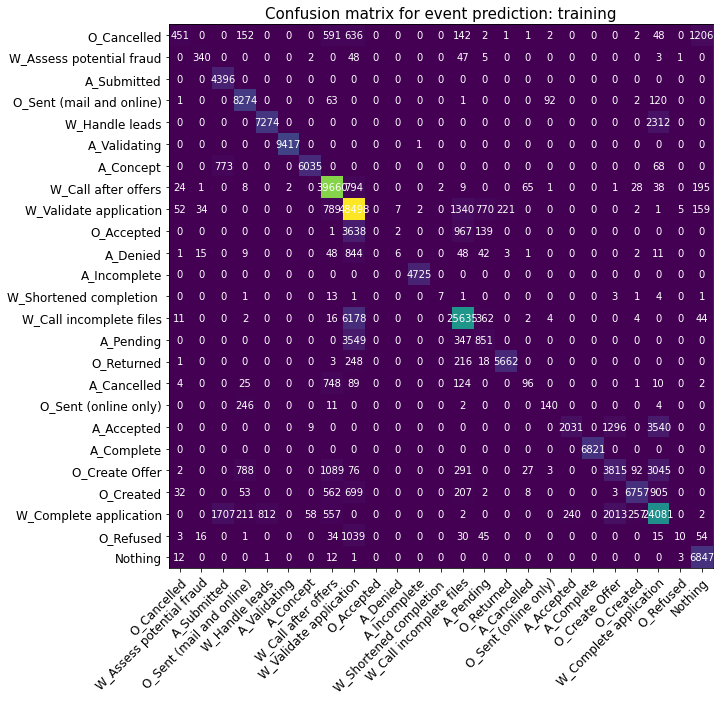

In [ ]:
build_confusion_matrix(train_true_event, train_rnn_event, 'training')

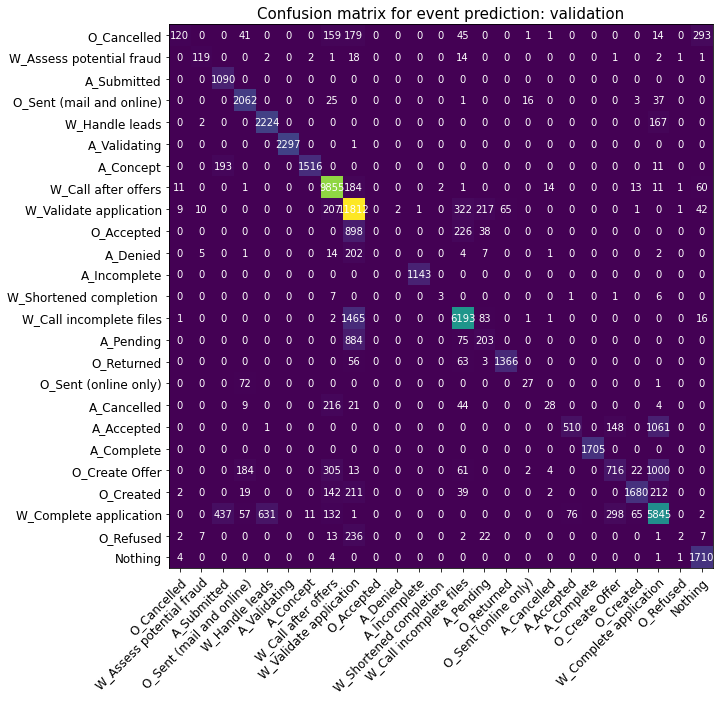

In [ ]:
build_confusion_matrix(val_true_event, val_rnn_event, 'validation')

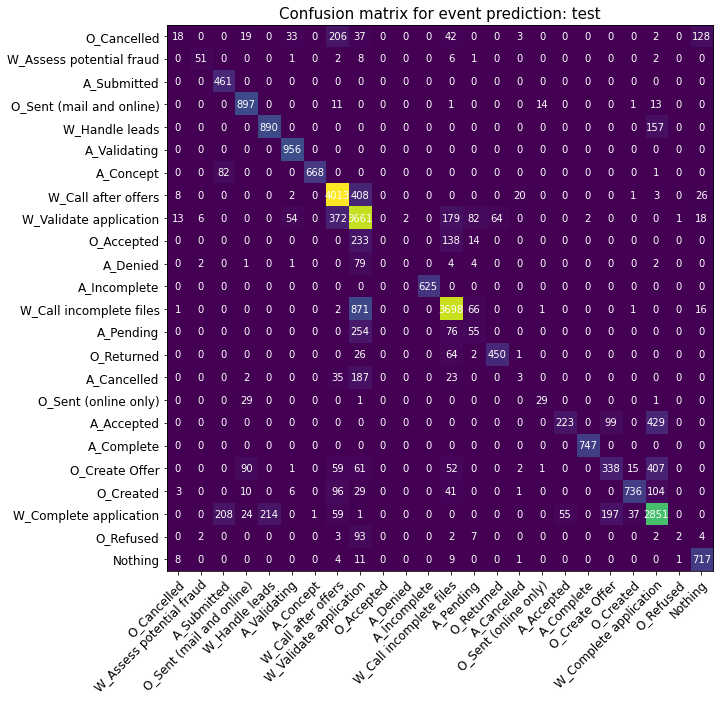

In [ ]:
build_confusion_matrix(test_true_event, test_rnn_event, 'test')

# 7. R2 and RMSE and MAE

In [ ]:
train_true = df_train['future_time_diff'].tolist()
val_true = df_val['future_time_diff'].tolist()
test_true = df_test['future_time_diff'].tolist()

train_rnn = df_train['RNN_time_diff'].tolist()
val_rnn = df_val['RNN_time_diff'].tolist()
test_rnn = df_test['RNN_time_diff'].tolist()

In [ ]:
math.sqrt(mean_squared_error(train_true, train_rnn)), math.sqrt(mean_squared_error(val_true, val_rnn)), math.sqrt(mean_squared_error(test_true, test_rnn))

(110801.11843477077, 115003.26267933894, 231936.9866360674)

In [ ]:
mean_absolute_error(train_true, train_rnn), mean_absolute_error(val_true, val_rnn), mean_absolute_error(test_true, test_rnn)

(21089.7217474873, 22029.494326472282, 42056.68807227737)

In [ ]:
r2_score(train_true, train_rnn), r2_score(val_true, val_rnn), r2_score(test_true, test_rnn)

(0.37231599688328143, 0.36444782150587796, 0.03631897082122515)

In [ ]:
df_train.to_csv('/content/drive/MyDrive/Process Mining RNN/output/bpi2017_train_output.csv', index = False)
df_val.to_csv('/content/drive/MyDrive/Process Mining RNN/output/bpi2017_val_output.csv', index = False)
df_test.to_csv('/content/drive/MyDrive/Process Mining RNN/output/bpi2017_test_output.csv', index = False)